In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("mumbai_real_load_data.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)


In [3]:
df['load_lag_1h'] = df['load_mw'].shift(1)
df['load_lag_24h'] = df['load_mw'].shift(24)
df['load_lag_168h'] = df['load_mw'].shift(168)
df.dropna(inplace=True)


In [4]:
cat_cols = ['region', 'season', 'population_density', 'primary_usage', 'distributor', 'affluence_level']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

num_cols = ['load_mw', 'temperature', 'humidity', 'load_lag_1h', 'load_lag_24h', 'load_lag_168h']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [5]:
features = ['temperature', 'humidity', 'hour', 'day_of_week', 'month',
            'is_weekend', 'is_festival', 'region', 'season', 'population_density',
            'primary_usage', 'distributor', 'affluence_level',
            'load_lag_1h', 'load_lag_24h', 'load_lag_168h']
X = df[features]
y = df['load_mw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
print("XGBoost R2 Score:", r2_score(y_test, xgb_pred))


XGBoost R2 Score: 0.9975767577500301


In [6]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # Only load_mw
    return np.array(X), np.array(y)

seq_features = ['load_mw', 'temperature', 'humidity']
data_seq = df[seq_features].values
seq_length = 48  # Better than 24 for short-term load

X_seq, y_seq = create_sequences(data_seq, seq_length)
X_seq_train, X_seq_test = X_seq[:int(0.8*len(X_seq))], X_seq[int(0.8*len(X_seq)):]
y_seq_train, y_seq_test = y_seq[:int(0.8*len(y_seq))], y_seq[int(0.8*len(y_seq)):]


In [7]:
gru = Sequential()
gru.add(Input(shape=(seq_length, len(seq_features))))
gru.add(GRU(64))
gru.add(Dense(1))
gru.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
gru.fit(X_seq_train, y_seq_train, epochs=20, batch_size=64, verbose=1, callbacks=[early_stop])

gru_pred = gru.predict(X_seq_test).flatten()
print("GRU R2 Score:", r2_score(y_seq_test, gru_pred))


Epoch 1/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 116s 50ms/step - loss: 0.0276
Epoch 2/20
   1/2283 ━━━━━━━━━━━━━━━━━━━━ 5:27 143ms/step - loss: 0.0128

C:\Users\priya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


2283/2283 ━━━━━━━━━━━━━━━━━━━━ 114s 50ms/step - loss: 0.0264
Epoch 3/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 155s 56ms/step - loss: 0.0249
Epoch 4/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 130s 57ms/step - loss: 0.0237
Epoch 5/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - loss: 0.0231
Epoch 6/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 130s 57ms/step - loss: 0.0224
Epoch 7/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - loss: 0.0223
Epoch 8/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 128s 56ms/step - loss: 0.0221
Epoch 9/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - loss: 0.0219
Epoch 10/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 130s 57ms/step - loss: 0.0216
Epoch 11/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 129s 56ms/step - loss: 0.0216
Epoch 12/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 128s 56ms/step - loss: 0.0218
Epoch 13/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 124s 54ms/step - loss: 0.0215
Epoch 14/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 108s 47ms/step - loss: 0.0218
Epoch 15/20
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 106s 47ms/step - loss: 0.02

In [10]:
min_len = min(len(xgb_pred), len(gru_pred))
hybrid_pred = (0.8 * xgb_pred[:min_len] + 0.2 * gru_pred[:min_len])

hybrid_actual = y_test.iloc[:min_len].values

print("Hybrid Model R2 Score:", r2_score(hybrid_actual, hybrid_pred))


Hybrid Model R2 Score: 0.9518051828892397


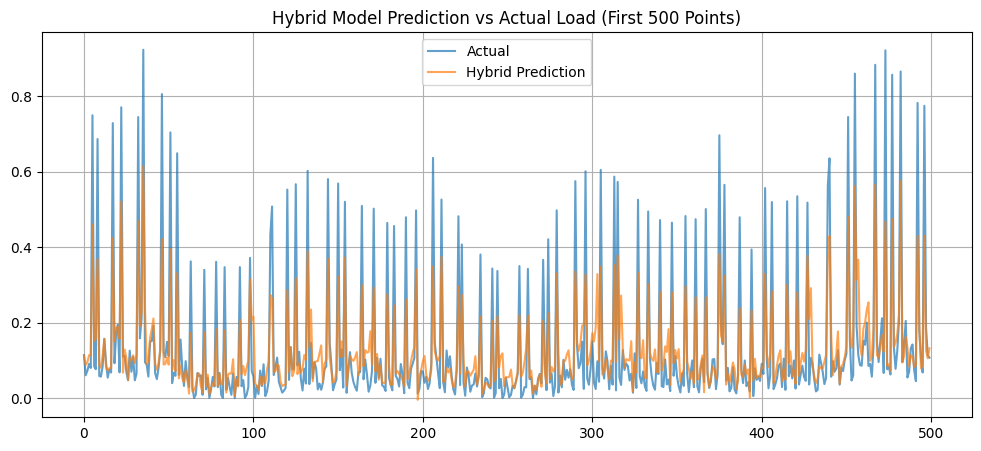

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(hybrid_actual[:500], label='Actual', alpha=0.7)
plt.plot(hybrid_pred[:500], label='Hybrid Prediction', alpha=0.7)
plt.title("Hybrid Model Prediction vs Actual Load (First 500 Points)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)


NameError: name 'y_true' is not defined

In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)


NameError: name 'y_true' is not defined

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate XGBoost performance
r2 = r2_score(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
mse = mean_squared_error(y_test, xgb_pred)
rmse = np.sqrt(mse)

print("XGBoost Evaluation Metrics:")
print("R² Score :", round(r2, 4))
print("MAE      :", round(mae, 4))
print("MSE      :", round(mse, 4))
print("RMSE     :", round(rmse, 4))


XGBoost Evaluation Metrics:
R² Score : 0.9976
MAE      : 0.0055
MSE      : 0.0001
RMSE     : 0.009
